In [2]:
pip install SALib

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib as plt
%pylab inline
import random
import seaborn as sns
from sklearn.utils import resample
import random
from matplotlib import rcParams
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X = pd.read_fwf('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/input_parameters_MARS_Sobol.txt',header=None)
X = pd.concat([X.iloc[:,0:14],X.iloc[:,15:]],axis=1)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24
0,0.0879,0.2807,0.1890,0.6511,0.2338,0.5177,0.4370,0.5888,0.0301,0.8195,0.6544,0.7529,0.2128,0.8716,0.7645,0.0646,0.5739,0.8696,0.9242,0.6375,0.6789,0.3913,0.4369,0.4186
1,0.5153,0.7686,0.6757,0.5967,0.9500,0.5352,0.0456,0.2252,0.5742,0.8978,0.6199,0.5928,0.9958,0.0723,0.8371,0.9858,0.2579,0.8629,0.5034,0.3296,0.4936,0.0931,0.8548,0.6775
2,0.3943,0.7704,0.0529,0.0090,0.0083,0.0688,0.9996,0.4619,0.7841,0.5631,0.9313,0.6107,0.0258,0.7818,0.7701,0.5131,0.8486,0.0055,0.0146,0.1163,0.5348,0.1600,0.4304,0.2770
3,0.9446,0.0434,0.1577,0.5616,0.1896,0.5129,0.3456,0.1049,0.1073,0.3080,0.0194,0.0443,0.5737,0.0143,0.6521,0.7795,0.9952,0.0839,0.9828,0.6451,0.5836,0.4598,0.1285,0.5187
4,0.2402,0.6999,0.1658,0.3759,0.7166,0.1432,0.6049,0.3403,0.9557,0.4347,0.8471,0.4167,0.2357,0.0292,0.9426,0.3507,0.9338,0.2757,0.5799,0.5207,0.4799,0.2266,0.7071,0.2558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.7200,0.3279,0.9909,0.0051,0.3415,0.6969,0.6484,0.2871,0.1547,0.4594,0.2620,0.7938,0.1909,0.8634,0.3194,0.7340,0.3326,0.8797,0.4923,0.7535,0.1244,0.9696,0.3116,0.0283
246,0.2713,0.5085,0.6870,0.3099,0.1405,0.1688,0.4549,0.9789,0.9867,0.3027,0.1342,0.3405,0.0069,0.4022,0.7018,0.0780,0.3409,0.6678,0.8736,0.1796,0.6668,0.6349,0.6454,0.5673
247,0.7647,0.8047,0.2780,0.6781,0.1725,0.6587,0.7479,0.1495,0.7002,0.0661,0.8176,0.8944,0.8777,0.1477,0.0648,0.6901,0.8032,0.5433,0.8363,0.8531,0.5051,0.0842,0.7266,0.5565
248,0.0027,0.4330,0.0732,0.0001,0.1678,0.9175,0.2974,0.6741,0.4885,0.5709,0.6826,0.5682,0.4015,0.7462,0.2264,0.5925,0.2173,0.8426,0.5501,0.6062,0.5598,0.6600,0.5111,0.5459


In [6]:
Y = pd.read_excel('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/output_variables_MARS_Sobol_runs.xlsx',sheet_name='RMSE_variables',nrows=250,usecols = 'B:I')
Y

,WS10,SAT,SAP,RAIN,PBLH,OLR,DSWRF,DLWRF
0,2.722384,2.328833,923.620423,8.320000,388.357200,52.951052,126.561389,23.596080
1,2.332926,2.074557,919.679384,8.980714,388.174131,52.892022,143.018048,19.360958
2,3.045440,2.541654,922.728494,7.875313,389.717209,52.462319,120.150382,22.696423
3,2.868819,2.384805,921.612134,8.510566,388.918008,52.211615,148.857439,21.381934
4,2.673051,2.243006,919.469351,7.924683,382.371321,51.936048,140.067615,20.100543
...,...,...,...,...,...,...,...,...
245,2.271949,2.308478,925.976314,8.201370,385.797599,54.516736,121.394565,23.346654
246,2.315647,2.079771,922.183060,8.144154,374.233830,54.454176,126.689549,20.618247
247,2.572847,2.254726,922.197317,8.628788,399.124852,61.342643,130.509279,21.368687
248,2.972289,2.249624,924.608892,8.566329,387.909723,54.808774,122.192953,22.957464


In [12]:
Y=(Y-Y.min())/(Y.max()-Y.min())

In [7]:
problem = {
    'num_vars': 24,
    'names': ['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10',
              'P11', 'P12', 'P13','P14', 'P15', 'P16','P17', 'P18', 'P19','P20',
              'P21', 'P22', 'P23','P24'],
    'bounds': [[0,1],[0,1],[0,1],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1]]       
}

In [9]:
param_values = saltelli.sample(problem, 1024, calc_second_order=True)

In [10]:
param_values.shape

(51200, 24)

In [11]:
max(param_values[:,0])

0.9990234375

In [13]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RationalQuadratic, RBF
s1 = np.zeros((1,24))
st = np.zeros((1,24))
for i in range(8):
  y = Y.loc[:,Y.columns[i]]
  kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((24,1))) + WhiteKernel(noise_level=1e-10)
  model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
  model.fit(X, y)
  y_hat = model.predict(param_values)
  Si = sobol.analyze(problem, y_hat, print_to_console=False)
  print(Si['ST'])
  dmy = Si['ST']
  dmy = dmy.reshape((1,24))
  st = np.append(st,dmy,axis=0)
  dmy = Si['S1']
  dmy = dmy.reshape((1,24))
  s1 = np.append(s1,dmy,axis=0)

[2.59148216e-05 3.71115009e-02 7.66040155e-01 1.14517274e-01
 1.19544366e-02 6.36963545e-03 9.73641780e-03 3.34703530e-16
 2.39900510e-03 1.14052106e-03 4.00582413e-04 1.35727772e-04
 1.13524974e-14 1.25681724e-03 2.24824334e-15 9.56286862e-17
 4.62546450e-04 8.91727916e-05 4.56486445e-14 1.35993940e-04
 6.94931287e-05 5.09895592e-02 8.65520689e-04 3.00288840e-03]
[2.60876869e-03 4.18520859e-05 9.18357119e-04 2.79644690e-03
 7.01491946e-03 9.00921697e-03 3.97848936e-03 2.29931187e-18
 3.74759590e-03 4.60995963e-04 2.70008169e-17 1.12557357e-04
 2.96427498e-14 3.70359130e-01 1.70186479e-02 2.36793761e-04
 6.42744285e-01 4.89364839e-04 3.20956170e-04 1.99965853e-15
 3.98944652e-04 4.75841342e-03 4.01025413e-04 1.01043785e-05]
[7.86295984e-05 3.64775832e-04 2.00818358e-02 2.34674791e-01
 6.53408488e-02 2.61096108e-01 5.61966237e-02 1.89875700e-12
 4.55763587e-04 6.85643183e-02 6.66889564e-04 9.47727026e-16
 2.90624866e-13 4.90141924e-01 6.69248690e-03 3.56195407e-03
 2.02840832e-02 1.7313

In [14]:
y.shape

(250,)

In [15]:
s1 = s1[1:,:]
st = st[1:,:]
st.shape

(8, 24)

In [16]:
df = pd.DataFrame(data=st,
                    index=['WS10','SAT','SAP','RAIN','PBLH','OLR','DSWRF','DLWRF'],
                    columns=problem['names'])
df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24
WS10,2.591482e-05,3.711150e-02,7.660402e-01,0.114517,0.011954,0.006370,0.009736,3.347035e-16,2.399005e-03,1.140521e-03,4.005824e-04,1.357278e-04,1.135250e-14,0.001257,2.248243e-15,9.562869e-17,4.625465e-04,8.917279e-05,4.564864e-14,1.359939e-04,6.949313e-05,0.050990,8.655207e-04,3.002888e-03
SAT,2.608769e-03,4.185209e-05,9.183571e-04,0.002796,0.007015,0.009009,0.003978,2.299312e-18,3.747596e-03,4.609960e-04,2.700082e-17,1.125574e-04,2.964275e-14,0.370359,1.701865e-02,2.367938e-04,6.427443e-01,4.893648e-04,3.209562e-04,1.999659e-15,3.989447e-04,0.004758,4.010254e-04,1.010438e-05
SAP,7.862960e-05,3.647758e-04,2.008184e-02,0.234675,0.065341,0.261096,0.056197,1.898757e-12,4.557636e-04,6.856432e-02,6.668896e-04,9.477270e-16,2.906249e-13,0.490142,6.692487e-03,3.561954e-03,2.028408e-02,1.731358e-12,5.204385e-03,4.168824e-04,1.696129e-04,0.020151,5.580562e-03,2.658090e-16
RAIN,5.775100e-18,1.372911e-03,6.938103e-03,0.128641,0.022102,0.694868,0.078415,4.572290e-16,5.069985e-03,8.508789e-03,8.338434e-15,8.369238e-03,2.722772e-14,0.010830,1.384713e-04,1.657630e-04,6.730952e-03,1.377970e-04,7.900489e-17,2.680835e-05,2.439274e-04,0.040315,1.714379e-03,1.802031e-03
PBLH,5.925059e-04,3.209218e-03,9.030929e-03,0.015537,0.056580,0.028414,0.042140,2.016366e-12,3.367445e-02,9.333094e-08,1.382853e-12,1.545781e-03,7.545762e-05,0.149318,2.384859e-05,5.065977e-04,2.034994e-01,1.552495e-05,4.678269e-03,1.397927e-03,1.986657e-01,0.440974,7.549917e-03,2.938808e-10
OLR,2.350332e-17,2.459824e-05,7.692590e-05,0.002769,0.010004,0.038484,0.028764,4.331147e-12,2.781368e-11,8.557202e-01,2.168822e-03,2.105785e-01,1.574260e-11,0.000629,1.243596e-02,9.766513e-05,8.921029e-04,1.905156e-05,1.391488e-10,5.153534e-13,4.161661e-12,0.000580,2.398289e-11,2.201274e-10
DSWRF,2.240195e-16,5.802176e-16,4.399642e-14,0.001309,0.002698,0.001969,0.002762,1.713738e-04,6.537693e-02,6.115101e-02,6.262690e-04,1.673671e-02,1.185436e-04,0.864934,1.360418e-04,6.174451e-14,1.229047e-11,8.451461e-05,5.844303e-06,1.388926e-05,1.907854e-04,0.027155,2.540278e-03,1.882030e-05
DLWRF,2.441075e-12,2.664762e-13,5.834528e-03,0.005700,0.002226,0.055856,0.001788,1.428978e-13,1.206116e-01,2.362577e-02,1.599404e-04,7.540096e-04,1.382863e-12,0.390638,3.310064e-01,4.620301e-04,7.008412e-02,4.430983e-14,5.455152e-04,2.265892e-05,2.511517e-14,0.020511,2.576882e-03,4.496438e-11


In [17]:
df_t = df.T
df_t = (df_t-df_t.min())/(df_t.max()-df_t.min())
df = df_t.T

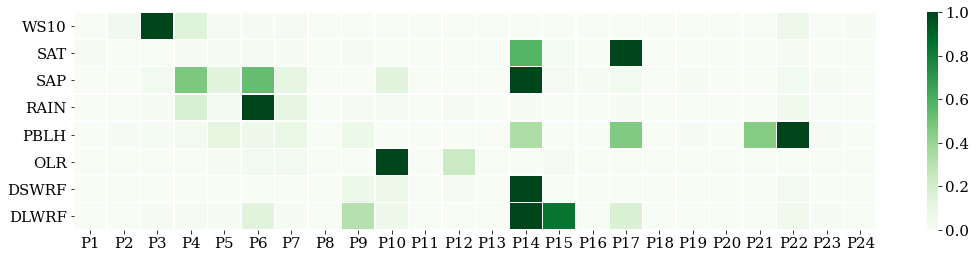

In [18]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
ax = plt.figure(figsize=(18,4))
ax = sns.heatmap(df,cmap="Greens",linewidths=.5)
plt.xticks(rotation='horizontal')
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/Sobol_heatmap.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)

In [19]:
df.sum(axis=0).sort_values(ascending=False)

P14    3.932785
P6     1.809698
P17    1.693604
P10    1.285518
P22    1.257675
P3     1.087890
P15    0.902424
P4     0.872335
P9     0.477894
P21    0.452145
P7     0.383348
P5     0.340452
P12    0.283266
P2     0.058537
P23    0.042261
P19    0.023130
P16    0.010320
P24    0.006551
P1     0.005597
P11    0.005552
P20    0.004311
P18    0.001231
P13    0.000308
P8     0.000198
dtype: float64

In [20]:
SI = df.sum(axis=0).sort_values(ascending=False)
SI.to_csv(r'/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/Sobol_SI.csv',header=None,index=True)

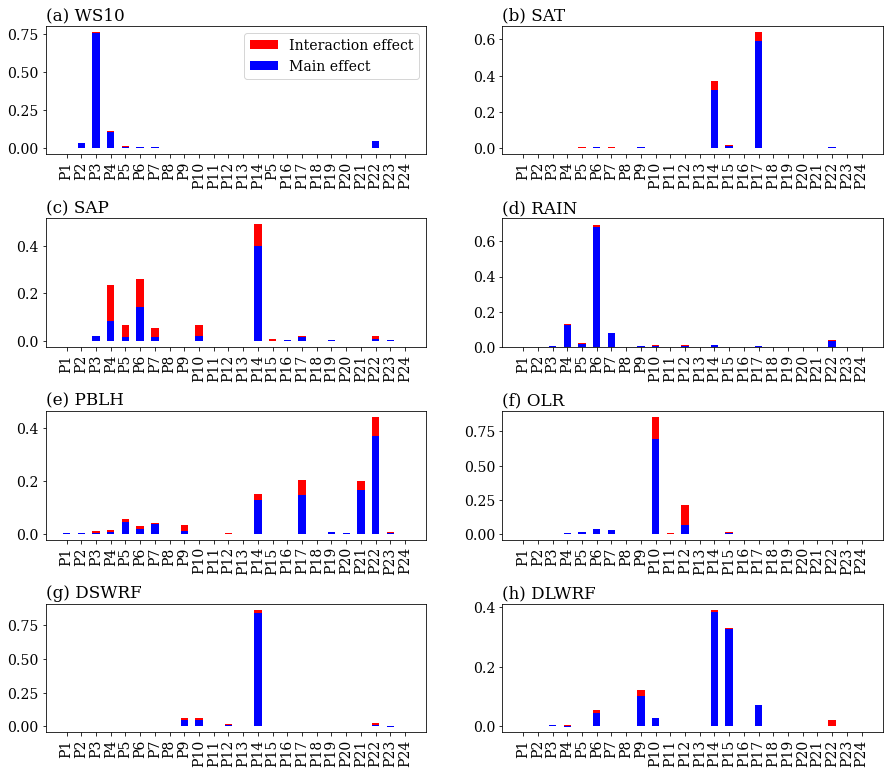

In [21]:
fig = plt.figure(figsize=(15,13))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14) 
x = np.arange(24)
width = 0.5
ABC = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
i=0
ax = fig.add_subplot(4,2,i+1)
ax.bar(x,st[i,:],width,color='red')
ax.bar(x,s1[i,:],width,color='blue')
ax.set_xticks(x)
ax.set_xticklabels(['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10',
              'P11', 'P12', 'P13','P14', 'P5', 'P16','P17', 'P18', 'P19','P20',
              'P21', 'P22', 'P23','P24'],rotation='vertical')
ax.legend(['Interaction effect','Main effect'],loc='upper right')
ax.set_title(ABC[i]+' '+df.index[i],loc='left')
for i in range(1,8):
  ax = fig.add_subplot(4,2,i+1)
  ax.bar(x,st[i,:],width,color='red')
  ax.bar(x,s1[i,:],width,color='blue')
  ax.set_xticks(x)
  ax.set_xticklabels(['P1', 'P2', 'P3','P4', 'P5', 'P6','P7', 'P8', 'P9','P10',
                'P11', 'P12', 'P13','P14', 'P15', 'P16','P17', 'P18', 'P19','P20',
                'P21', 'P22', 'P23','P24'],rotation='vertical')
  ax.set_title(ABC[i]+' '+df.index[i],loc='left')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/Sobol_effects.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)

In [22]:
dmy = df_t.iloc[:,0]*100/df_t.iloc[:,0].sum()
index = dmy.index
dmy.index = np.arange(0,24)
sorted = dmy.sort_values(ascending=False)
sorted
index[sorted.index[0]]

'P3'

In [23]:
str(np.arange(0,101,10))

'[  0  10  20  30  40  50  60  70  80  90 100]'

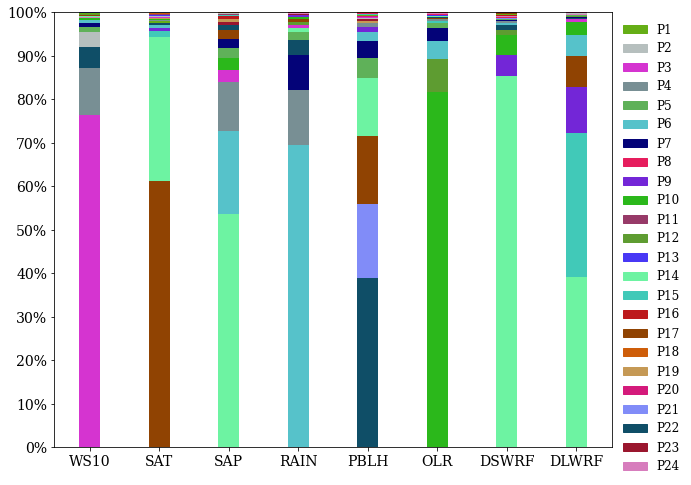

In [28]:
df = pd.DataFrame(data=s1,
                    index=['WS10','SAT','SAP','RAIN','PBLH','OLR','DSWRF','DLWRF'],
                    columns=problem['names'])
df_t = df.T
df_t = (df_t-df_t.min())/(df_t.max()-df_t.min())
df = df_t.T
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
colors = np.random.random((24,3))   # Colors chosen to be random. Thus, figure colors will vary at each run
width = 0.3
ax = fig.add_subplot(1,1,1)
for k in range(8):
  dmy = df_t.iloc[:,k]*100/df_t.iloc[:,k].sum()
  index = dmy.index
  dmy.index = np.arange(0,24)
  sorted = dmy.sort_values(ascending=False)
  ax.bar(k,sorted.iloc[0],width,color=colors[sorted.index[0],:])
  for i in arange(0,24):
    bottom = 0
    for j in arange(0,i):
      bottom = bottom+sorted.iloc[j]
    ax.bar(k,sorted.iloc[i],width,bottom=bottom,color=colors[sorted.index[i],:])
#plt.legend(index, fancybox=True,colors = colors)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(df.index)
ax.set_yticks(np.arange(0,101,10))
ax.set_yticklabels(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
ax.legend(index,fontsize=12, ncol=1, framealpha=0, fancybox=True,bbox_to_anchor=(1, 1))
leg = ax.get_legend()
for i in range(24):
  leg.legendHandles[i].set_color(colors[i])
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/Sobol__primary_effects.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)

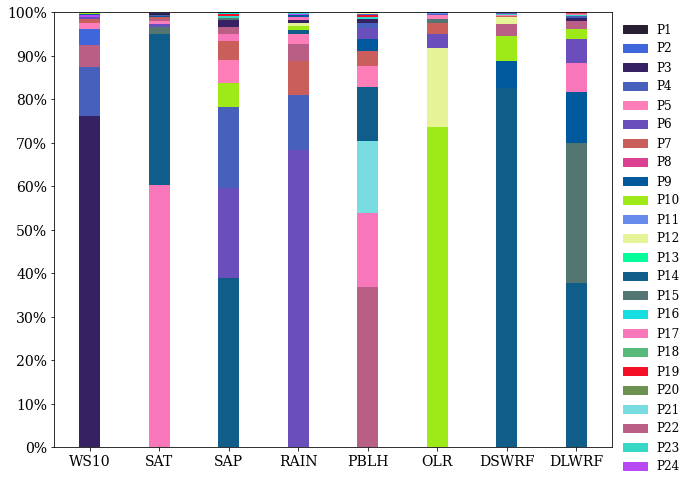

In [27]:
df = pd.DataFrame(data=st,
                    index=['WS10','SAT','SAP','RAIN','PBLH','OLR','DSWRF','DLWRF'],
                    columns=problem['names'])
df_t = df.T
df_t = (df_t-df_t.min())/(df_t.max()-df_t.min())
df = df_t.T
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
#colors = np.random.random((24,3))
width = 0.3
ax = fig.add_subplot(1,1,1)
for k in range(8):
  dmy = df_t.iloc[:,k]*100/df_t.iloc[:,k].sum()
  index = dmy.index
  dmy.index = np.arange(0,24)
  sorted = dmy.sort_values(ascending=False)
  ax.bar(k,sorted.iloc[0],width,color=colors[sorted.index[0],:])
  for i in arange(0,24):
    bottom = 0
    for j in arange(0,i):
      bottom = bottom+sorted.iloc[j]
    ax.bar(k,sorted.iloc[i],width,bottom=bottom,color=colors[sorted.index[i],:])
#plt.legend(index, fancybox=True,colors = colors)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(df.index)
ax.set_yticks(np.arange(0,101,10))
ax.set_yticklabels(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
ax.legend(index,fontsize=12, ncol=1, framealpha=0, fancybox=True,bbox_to_anchor=(1, 1))
leg = ax.get_legend()
for i in range(24):
  leg.legendHandles[i].set_color(colors[i])
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/Sobol__total_effects.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)